<img src="imgs/logo.png" width="100%">
-----

## Probabilistic filtering for intention inference

### Particle filters: Sequential Monte Carlo estimation


### Problem description
We are going to solve a simple problem:

* Recognising simple 2D gestures, drawn with a mouse.

This is readily solved with "standard" machine learning algorithms, but we will show how a model-led approach lets us encode our assumptions elegantly **and** we get all the benefits of *probabilistic* tracking. We'll see how probabilistic filters degrade gracefully when our models are bad or measurements are noisy.

<img  src="imgs/capture.png" width="80%"/>

#### Algorithm
We will use the **particle filter** algorithm (technically the **SIR** variant, which is the simplest to understand).


## Why particle filter?
The Kalman filter used the normal distribution to model all of the uncertainty in the system. This is great for efficiency, since the updates are simple linear transforms. But it has several significant drawbacks, which make it difficult to apply directly to infer gestures from observations:

#### Kalman filter drawbacks
* the **dynamics** have to be linear: we can't have complicated dynamic models (although we can linearise at each time step).

This doesn't make much sense for tracking complex gesture trajectories; a dynamic model for a complete gesture is rarely going to be linear.

* the **uncertainty** must be normal: so we can't track multiple modes, for example, because a normal distribution has exactly one mode. 

Imagine an object disappearing behind an obstruction which could reappear on either side; the Kalman filter can only spread out the distribution over the whole area, with an expected location in the middle of the obstacle! We would like to instead be able to track the two possibilities here by splitting up the hypotheses.

<img src="imgs/landscape.png">
*[Waddington's epigenetic landscape, illustrating a dynamic system which develops multiple modes as it evolves; a Gaussian approximation is wholly inappropriate]*

This is critical in gesture recognition for example; at any point in time, our hypotheses might be split among multiple possible gestures with different spatial distributions. Being able to represent the combination of discrete + continuous states is critical. (**Kalman filter banks** are an alternative approach, which explicitly maintain the competing hypotheses as separate Kalman filters).

----

### Particle Filtering 
Particle filters are very simple to understand:

* Instead of trying to represent the PDFs of our distributions, which could be any function that integrates to unity, we represent **distributions** using **samples** from those distributions (i.e. it is a **sequential Monte Carlo** method; we use samples to represent distributions). We choose some fixed number of particles $N_s$ and have a set of particles $S_t = \{ x^{1}_t, x^{2}_t, \dots, x^{N_s}_t \}$.
* we can apply **any** dynamics simply by applying our dynamics function $f$ to each sample from our current set $S_t$ to get a new predicted set of samples $S_{t+1}$. Likewise, for any sample, we can compute the corresponding observation by applying an arbitrary function $g$ to each sample independently. There are **no** restrictions on the form of $f$ and $g$.
* Our uncertainty is captured by the locations of the set of particles in the state space; they are samples from our current posterior. We do not have an explicit parametric form for the distribution; samples are all that we have. Therefore there are no restrictions on the form of the distribution; it can be multi-modal, heavy-tailed etc. 
* We don't explicitly compute the likelihood of observations, but instead we apply some weighting function to the particles and then normalise these weights to approximate the likelihood. This means we only have to find a reasonable weighting function, and not a true likelihood.
* We **resample** particles which are likely after an observation, and discard those which are unlikely. This is **importance resampling**. Without this step, particles would quickly diffuse into very unlikely parts of the space. **Importance resampling** continuously adapts the particles to cover likely portions of the space.

**This can only ever approximate the "true" distribution; but the Monte Carlo approximation turns out to work surprisingly well, and has good theoretical guarantees. **

<img src="imgs/particleprocess.png">


---

<video src="videos/anim.mpg.webm">


<video src="videos/leafv.mpg.webm">

---

It might seem surprising that would work, but in fact for many problems it works very well, and it is statistically sound (under relatively relaxed conditions). It is less computationally efficient than the Kalman filter, and also less inferentially efficient (it is usually less certain for the same amount of data). 

It has many, many variants and many parameters that can be tweaked. This is flexible, but can be hard to optimize.



Particle filters have many uses in HCI. For example, we have used them extensively to track finger configurations when using capacitive sensors. In this case, we have a finger pose state space (hidden) and a sensor matrix (observed), and the filter estimates pose in real-time.

<img src="imgs/anglepose.jpg">
[See the AnglePose video](http://www.dcs.gla.ac.uk/~jhw/AnglePose-final.mov)

## Specifying a particle filter
A particle filter requires that we specify:
* A **dynamics function** $f({\bf {x}}_t)$ that predicts how we expect the world to evolve, which takes 
${\bf{x}}^k_t \rightarrow {\bf x}^k_{t+1}$ for any given sample ${\bf{x}}^k_t$.
* An **observation function** $g({\bf x}_{t})$ that predicts what we expect to observe, given a hypothesized state: ${\bf{x}_t^k} \rightarrow  \hat{\bf y}_t^k $
* A **weight function**, that, given a hypothesized observation $\hat{\bf y}_t^k$, can be used to compute $p(\hat{\bf y}_t|{\bf y}_t)$. This is performed by computing weights $w_k$ for each particle $\bf x^k$ and then normalizing to produce the per-sample likelihood:
$$p^{(k)}(\hat{\bf y}_t|{\bf y}_t) = \frac{w_k}{\sum_j w_j}$$
* A set of **prior distributions** that specify our initial guesses for $\hat{\bf x}_0$, and allow us to draw the samples $\{ \hat{\bf x}^1_0, \hat{\bf x}^2_0, \dots, \hat{\bf x}^{N_s}_0 \}$

### Basic filtering
We will first implement a basic particle filter that can track a very simple one dimensional time series. This toy problem is easy to understand and work with.

Then, we will show how this can generalise to an interesting HCI problem.

In [3]:
# import the things we need
from __future__ import print_function, division
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pfilter
pfilter = reload(pfilter)
import ipywidgets
import IPython
import matplotlib, matplotlib.colors
matplotlib.rcParams['figure.figsize'] = (14.0, 8.0)
%matplotlib inline
from scipy.stats import norm

In [4]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;
OutputArea.prototype._should_scroll = function(){return false};

<IPython.core.display.Javascript object>

### Some test data
To test the particle filter, we will try and track a very simple, 1D sine wave:
$$Y_t=\sin(t)$$

This is a simple, smooth process.
We will try and estimate our "hidden" value $\bf{X}$ via an observed variable $\bf{Y}$ which is just $\bf X$ with some noise added.

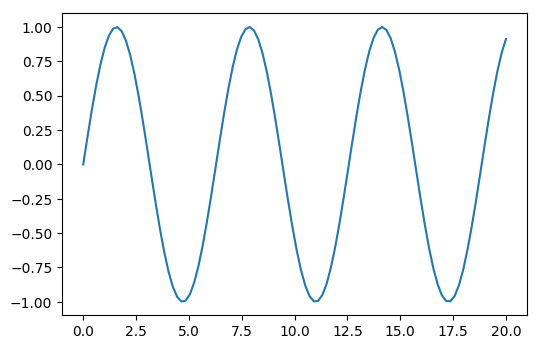

In [5]:
# 100 points sampled from a sine wave
t = np.linspace(0,20,100).reshape(-1,1)
x = np.sin(t)
plt.plot(t,x)

### Simple model
We will use a very simple model

* **Dynamics**
We assume that there are no predictable dynamics, just some Gaussian noise $X_t = X_{t+1} +  N(0,\sigma_p)$

In [6]:
sigma_p = 0.2              # the process noise 

In [7]:
### Identity Example
def dynamics(x):
    # tomorrow is the same as today
    # but slightly randomly different
    # we literally *add* noise to our previous state
    return np.random.normal(x, sigma_p,x.shape)

We can show what this dynamics model looks like, if we had no resampling step in the filter. This makes predictions without ever having seen any data.

The result is just a random walk; our predictive model is not very strong!

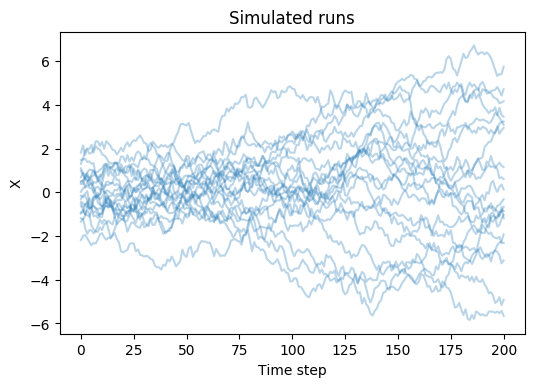

In [8]:
def simulate_dynamics(priors, dynamics, steps, n_runs=1):
    runs = []
    def simulate_run():
        # draw samples from the priors
        x = np.array([p() for p in priors])
        xs = [x]    
        for i in range(steps):
            x = dynamics(x)
            xs.append(x)
        return xs    
    return np.array([simulate_run() for j in range(n_runs)])
    
# run the simulation 20 times for 200 time steps each time
# we use a normal distribution as our prior on starting value
simulated = simulate_dynamics(priors=[norm(0,1).rvs], dynamics=dynamics, steps=200, n_runs=20)   
plt.plot(simulated[:,:,0].T, alpha=0.3, c='C0');
plt.xlabel("Time step")
plt.ylabel("X")
plt.title("Simulated runs")

* **Observation**
We assume that the sensor we measure **is** the value we want to infer, i.e. $\bf y_t=x_t$, and therefore $g({\bf x_t})$  is just the identity.

In [9]:
def observe(x):
    # we observe x directly
    return x[:,0]

* **Weighting**
We weight samples according to how similar they are to the observed output. We use a simple **heat kernel**:
$$w_i = e^{\left(-\frac{(y-y^\prime)^2}{2\beta^2}\right)}$$
$\beta$ is a parameter that lets us specify how precise our matching between observation and reality is.

Note that this gives more weight to particles that are more similar to the observation: it is a **similarity** function, not a distance function.

In [10]:
beta = 0.25                # the RBF width

def weight(true_y, hypothesized_y):
    # RBF similarity function       
    w = np.exp(-np.sum((hypothesized_y-true_y)**2, axis=0)/(0.5*beta**2))    
    return w

We can see what this function looks like, comparing a true value of 0 with values in [-1, 1], $\beta=0.25$:

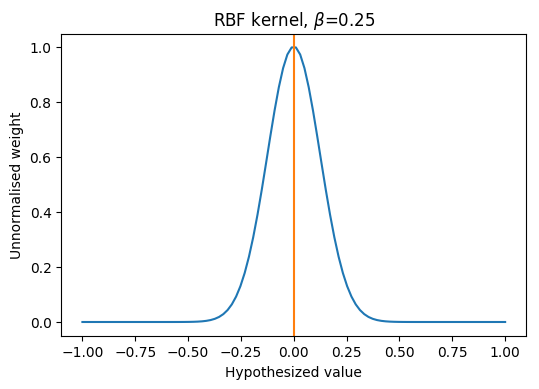

In [11]:
# plot the weight as a function of difference to hypothesized value
hypo = np.linspace(-1,1,100).reshape(1,100)
plt.plot(hypo.reshape(100,), weight(0, hypo))
plt.axvline(0,c='C1')
plt.xlabel("Hypothesized value")
plt.ylabel("Unnormalised weight")
plt.title("RBF kernel, $\\beta$=0.25")

**Priors**
We assume a very simple prior on $X$; that it is normally distributed, mean 0, variance 1, $X_0 \sim N(0,1)$

In [12]:
# we assume that, before seeing any evidence, that the particles are 
# normally distributed about 0, with std. dev. 1.0
prior = [norm(0,1)] # x ~ N(0,1)

## Filter creation
We use a simple implementation of a particle filter, which simply takes these functions and the number of particles to use in the sampling process.

In [13]:
pf_simple = pfilter.ParticleFilter(initial=prior, 
                                    observe_fn=observe,
                                    n_particles=200,                                    
                                    dynamics_fn=dynamics,
                                    weight_fn=weight,                    
                                    resample_proportion=0.02)

In [14]:
def run_pfilter(pfilter, inputs):
    """Apply a particle filter to a time series of inputs,
    and return the particles, their weights, and the mean
    estimated state"""    
    # reset filter
    pfilter.init_filter()
    particles, weights, means = [], [], []
    # apply to each element of the time series
    for i in range(len(inputs)):           
        pfilter.update([inputs[i]])
        particles.append(pfilter.original_particles)    
        weights.append(pfilter.weights)
        means.append(pfilter.mean_state)        
    return np.array(particles), np.array(weights), np.array(means)

We define a utility function to plot the results of running a particle filter:

In [40]:
import particle_utils
particle_utils = reload(particle_utils)
from particle_utils import plot_pfilter, animate_pfilter


## Running the estimator

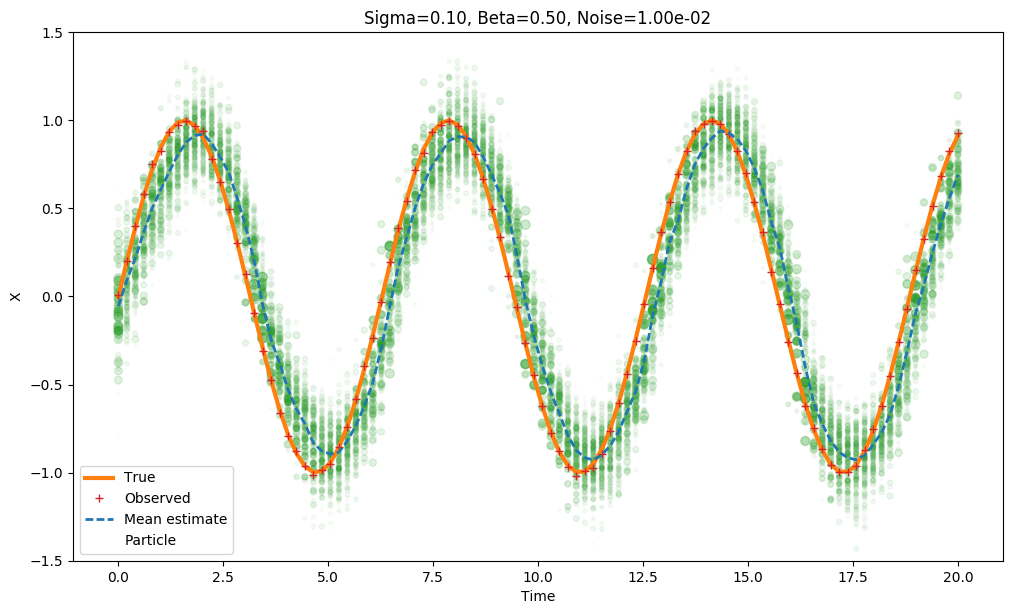

Exception in Tkinter callback
Traceback (most recent call last):
  File "c:\python27\lib\lib-tk\Tkinter.py", line 1536, in __call__
    return self.func(*args)
  File "c:\python27\lib\lib-tk\Tkinter.py", line 587, in callit
    func(*args)
  File "tkanvas.py", line 109, in update
    self.draw_fn(self)
  File "particle_utils.py", line 47, in draw_pf
    t,x,y = ts[i], xs[i], ys[i]
IndexError: index 100 is out of bounds for axis 0 with size 100


Exiting...


In [33]:
def run_filter(sig=0.1, bet=0.5, noise=-2):
    global sigma_p, beta, noise_level, frame
    sigma_p = sig
    beta = bet
    noise_level = 10**noise
    noise = np.random.normal(0, noise_level, x.shape)
    plt.figure(figsize=(12,7))
    y = x + noise
    particles, weights, means = run_pfilter(pf_simple, y)
    animate_pfilter(t,x,y,particles,weights,means)
    plot_pfilter(t, x, y, particles, weights, means)
    %gui tk
    plt.title("Sigma=%.2f, Beta=%.2f, Noise=%.2e" % (sigma_p, beta, noise_level))
    plt.ylim(-1.5, 1.5)
    
run_filter(sig=0.1, bet=0.5, noise=-2)

Let's adjust these interactively

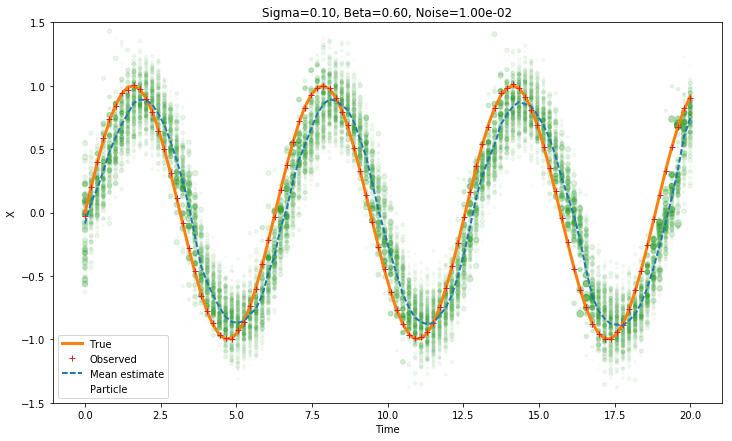

Exiting...


In [297]:
ipywidgets.interact_manual(run_filter, sig=(0.0, 2, 0.05), bet=(0.1, 5.0, 0.1), noise = (-5.0, 1.0, 0.1))

#### Things to note
* This is a trivial model, but still tracks "complex" functions, because it is adapting to observations
* Things to adjust:
    * noise level
    * rbf width beta
    * dynamics noise sigma



## A more interesting example
Imagine we wanted to infer the **phase** of the oscillator driving this sine wave. The phase variable is not observable, but we can  infer it from the observed oscillation. Furthermore, we want the *unwrapped* phase, i.e. we expect the phase to monotonically increase. We also **drop** some of our data to show how the filter responds when observations are not available; the filter has to *predict* without correction in the absence of observation.

<img src="imgs/phase.gif">
*[Image credit:1ucasvb]*

We can encode these assumptions in our model, then see if the particle filter is able to infer the hidden parameter over time.

* **Observation**
We postulate an observation model:
$$Y_t = \sin(X_t)$$
i.e. that what we see is the effect of sine on a hidden variable $X_t$.
Because we defined $Y_t=\sin(t)$, we are actually trying to infer $t$.

* **Dynamics**
We assume that we have a very simple dynamical system in discrete time, where we have a velocity and a position.
$$X_t = \begin{bmatrix}x \\ \dot{x}\end{bmatrix},$$ and 
$$X_{t+1} = X_t + \begin{bmatrix}\dot{x} \\ 0 \end{bmatrix}.$$

This means that if we start linearly increasing or decreasing at a certain rate, we should expect to keep doing so.

* **Priors**
We again assume that the initial distribution is normally distributed.


In [41]:
### Example
sigma_x = 0.1
sigma_dx = 0.001
def linear_dynamics(x):        
    nx = np.dot(x,np.array([[1,0],
                            [1,1]]))        
    process_sigmas = [sigma_x, sigma_dx] # how much noise for x and dx    
    nx += np.random.normal(0,process_sigmas,x.shape)
    return nx

def observe_sin(x):    
    # y = sin(x)    
    return np.sin(x[:,0])

def weight_sin(true_y, hypothesized_y):    
    return np.exp(-np.sum((true_y-hypothesized_y)**2, axis=0)/beta)
    
from scipy.stats import norm
prior = [norm(0,1), norm(0,0.25)] 
# drop some of the data

pf_sin = pfilter.ParticleFilter(initial=prior, 
                                observe_fn=observe_sin,
                                n_particles=200,
                                dynamics_fn=linear_dynamics,
                                weight_fn=weight_sin,                    
                                resample_proportion=0.01)

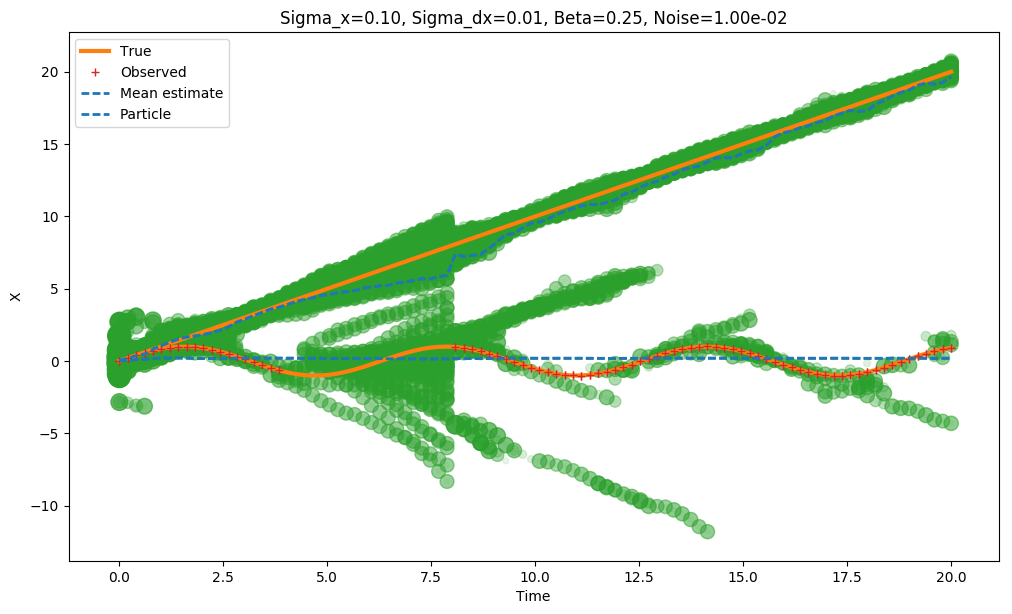

Exception in Tkinter callback
Traceback (most recent call last):
  File "c:\python27\lib\lib-tk\Tkinter.py", line 1536, in __call__
    return self.func(*args)
  File "c:\python27\lib\lib-tk\Tkinter.py", line 587, in callit
    func(*args)
  File "tkanvas.py", line 109, in update
    self.draw_fn(self)
  File "particle_utils.py", line 47, in draw_pf
    t,x,y = ts[i], xs[i], ys[i]
IndexError: index 100 is out of bounds for axis 0 with size 100


Exiting...


In [43]:

def run_sinfilter(sig_x=0.1, sig_dx=0.01, bet=0.25, noise=-2):
    



    global sigma_p, beta, noise_level, frame
    sigma_x = sig_x
    sigma_dx = sig_dx
    beta = bet
    noise_level = 10**noise
    noise = np.random.normal(0,noise_level, x.shape)
    plt.figure(figsize=(12,7))
    y = x + noise
    y[20:40,:] = np.nan
    frame = 0
    particles, weights, means = run_pfilter(pf_sin, y)
    plot_pfilter(t, t, y, particles, weights, means)
    animate_pfilter(t,t,y,particles,weights,means, yscale=1/10.0)
    plot_pfilter(t, x, y, particles, weights, means)
    %gui tk
    plt.title("Sigma_x=%.2f, Sigma_dx=%.2f, Beta=%.2f, Noise=%.2e" % (sigma_x, sigma_dx, beta, noise_level))
    
ipywidgets.interact_manual(run_sinfilter, sig_x=(0.0, 2, 0.05), sig_dx=(0.0, 0.5, 0.01), 
                           bet=(0.1, 5.0, 0.1), noise = (-5.0, 1.0, 0.1))    




#### Things to note
* The particle filter was able to infer the hidden state, despite only having a forward model (i.e knowledge of $\sin(x)$, **not** $\sin^{-1}(x)$)
* It correctly unwrapped phase, because we primed it with the dynamics model to expect values that would increase at a linear rate.
* This problem results in *multimodal* distributions, because there are an infinite number of solutions to $y=sin(x)$ because we can add any multiple of $2\pi$ without changing anything.
We can see these as fainter lines on the particle plot.
* This means that the particle mean is not actually a good estimate in this case! A better choice might be the most likely particle -- the Maximum A Posteriori (MAP) estimate.

---------------

## Challenge: Gesture recognition
Lets now apply these ideas to a practical HCI task: recognising 2D gestures.

We will base our algorithm directly on the one given in [A Probabilistic Framework for Matching
Temporal Trajectories](http://www.cs.toronto.edu/~jepson/papers/BlackJepsonECCV1998.pdf).

## Data
We have some example data with a few example 2D mouse-drawn gestures. Here we are assuming just a **single** template for each gesture, for simplicity.

In [24]:
import gestures
gestures = reload(gestures)
g = gestures.GestureData("gestures.txt")

## Gesture shapes 
We can plot the shapes of the gesture trajectories.

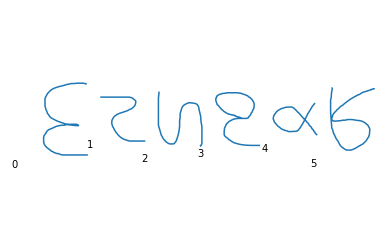

In [25]:
n_gestures = g.n_gestures
for i in range(n_gestures):
    plt.subplot(1, n_gestures,i+1)
    path = g.gestures[i]    
    plt.plot(path[:,0], path[:,1])
    plt.text(0,0,"%d"%i)
    plt.axis("off")
    plt.axis("equal")
    

## Timeseries view
We can also see each gesture as a trajectory of two coordinates ($x,y$ coordinates) over time. This is closer to the way in which the matching will work.

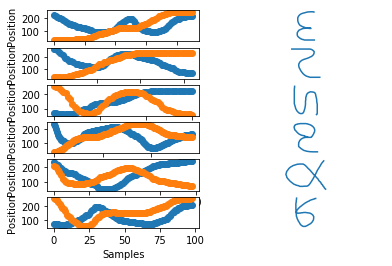

In [23]:
plt.figure()
for i in range(n_gestures):
    plt.subplot(n_gestures,2,i*2+1)    
    path = g.gestures[i]    
    plt.plot(path[:,0], 'oC0')
    plt.plot(path[:,0], '-C0')
    plt.plot(path[:,1], 'oC1')
    plt.plot(path[:,1], '-C1')
    plt.xlabel("Samples")
    plt.ylabel("Position")    
    plt.subplot(n_gestures,2,i*2+2)
    plt.plot(path[:,0], path[:,1], 'C0')
    plt.axis("equal")
    plt.axis("off")

### Problem
We want to recognize 2D gestures drawn with a mouse (or finger/stylus). 
* We *observe* sequences of $x,y$ coordinates over time.
* We have some example templates for particular shapes that we want to match (e.g. letters)
* We don't know:
    * where the user will start drawing a gesture
    * how big the gesture will be    
    * how fast the user will draw the gesture (it may well be drawn at a non-constant speed)
* We want to be able to identify:  
    * which gesture the user is performing, if any
    * when the user has finished doing the gesture
    
#### Probabilistic view
Putting this into the probabilistic framework, we want to infer a probability distribution over gesture classes and gesture completion state, given a time series of $x,y$ coordinates. The $x,y$ points form our observation vector $Y$.

We assume gesture reproduction is in some way a "noisy reproduction" of the ideal template form, where there are various types of distortion that can be encountered.

#### Markov approximation
We could look at the whole time series of $x,y$ points and try and classify that. However, there are two problems:
* What is the "whole" time series -- i.e. how do we segment the gesture?
* We would have to store the entire series and somehow match it against templates.

A simple way to eliminate these problems is to rewrite the recognizer so that it depends on nothing but its immediately previous state; i.e. so that it satisfies the Markov property.

To do this, we need to introduce additional variables into the state we are estimating; but with judicious choice these can be a very small number of additional variables. In particular, we can just track how far along a gesture we are (the "phase") and update that over time. 

### Parameters
We are now in a position to write down a model for our gesture recognizer.

### State
First of all, the state we are trying to infer:

<img src="imgs/gesture.png">

$${\bf x_t} = [i,s,x_c,y_c,\theta,\phi,\dot{\phi}]$$

We have one of $n$ possible gestures
* $i$ the number of the gesture

Our model says a gesture will be identical to the template for that class of gesture, but might vary in:
* $s$ overall scale, within some tolerance
* $x_c,y_c$ center position (could be anywhere on screen)
* $\theta$ small changes in rotation (e.g. $<45^o$)

We must take note that what we observe is a position at a **single time point** in a gesture. This means we must estimate how far through a gesture we are.
* $\phi$ the proportion of gesture complete, in the fraction [0,1].
* $\dot{\phi}$ the rate at which the gesture is being performed (i.e. fast or slow).


#### Observation

* Given a gesture $i$, we have a template $G_i(\phi)$, which is returns an $x,y$ point for any value of $\phi$.

* We expect to observe $\hat{{\bf y}}=AG_i(\phi)$, where $A$ is a transformation matrix applying the translation $x_c,y_c$, the scaling $s$ and the rotation $\theta$.

In [ ]:
def linear_transform(xys, angle=0.0, scale=1.0, translate=(0,0)):
    """Takes a an n x 2 array of point `xys` and returns the 2D points transformed by
    rotating by `angle` (degrees)
    scaling by `scale` (proportional 1.0=no change, 0.5=half, etc.)
    translating by `translate` ((x,y) offset)"""
    ca, sa = np.cos(a), np.sin(a)
    rot = np.array([[ca, -sa], 
                    [sa, ca]])
    return np.dot(rot, xys)*scale + np.array(translate)
    

def gesture_observation(state):
    # given an n x d matrix of n particle samples
    # return a n x 2 matrix of expected x,y, positions for that gesture model
    

#### Dynamics
We then specify some simple dynamics. These all allow the values to slowly change over time (i.e. some random drift), except for the phase $\phi$ which we also expect to steadily increase at the rate $\dot{\phi}$.

Specifically:
* $s_{t+1} = s_{t} + \sigma_s$ scale can drift slowly
* $x_{t+1} = x_{t} + \sigma_x$ position can drift slowly
* $y_{t+1} = y_{t} + \sigma_y$ position can drift slowly
* $\theta_{t+1} = \theta_{t} + \sigma_\theta$ orientation can drift slowly
* $i_{t+1}=i_{t}$  gesture class never changes
* $\phi_{t+1} = \phi_{t} + \dot{\phi}_{t} + \sigma_y$ progress is steady, with some drift
* $\dot{\phi}_{t+1} = \dot{\phi}_{t} + \sigma_y$ progress rate can drift

In [44]:
def dynamics_gesture(prev_states):
    # take an n x d array of particle samples
    # return an n x d array representing the next states
    return next_states

#### Priors
We then define our initial guesses for the state of the system, encoded as prior probability distributions.

* $s_0$ \sim $N(1,0.25)$, should be around original size, with some latitude
* $x_0,y_0$ \sim $U(0,\text{max_screen_size})$, could be anywhere on screen
* $\theta_0$ \sim $N(0,15)$, angle will be close to original, with std. dev. of ~15 degrees
* $\phi_0$ \sim $N(0,0.1)$, gestures will begin close to their start
* $\dot{\phi}_0$ \sim N($\mu_{\dot{\phi}}, \sigma_{\dot{\phi}})$), gesture speeds will be distributed according to the observed speeds from the template
* $i_0$ discrete \sim $U(0,n-1)$, could be any gesture

In [ ]:
def gesture_prior():
    pass
    # return a vector [i, s, x_c, y_c, \theta, \theta_dot] as an initial guess
    

### Weighting function
We again use the simple heat kernel (or RBF):
$$w_i = e^{\left(-\frac{(y-y^\prime)^2}{2\beta^2}\right)}$$
(the specific choice of weighting  function is rarely very important, except if there are particularly unusual states to be compared)

In [ ]:
def gesture_weight(observation, samples):
    # take a 2D observation (x,y)
    # and an n x d matrix of samples
    # return the weight for each, representing how similar they are
    

### Solution

In [ ]:
## Solution

# Outlook
---------------------
### Scope and limitations
#### Scope
* Probabilistic filters can be applied to many problems in HCI. Typically, if a process unfolds over time and there is uncertainty, a probabilistic filter is a strong candidate for inference. 

* The fact that inference is performed over time is a potential advantage over "static" classification approaches, as feedback can be generated on the fly, instead only after completion of an action. 

* In the specific context of gestures, the ability to infer the start and end-point of gestures can solve the "segmentation problem" or "gesture spotting problem" that is often awkward and leads to kludges like button presses to segment actions.

* Probabilistic motion models can easily be linked to higher-order probabilistic models which infer long-term actions on the part of the user. Because everything is a probability distribution, there is a simple common basis for integrating such models. This, for example, can include language models which estimate a distribution over text that is likely to be entered given both user input and a statistical model of language.

#### Limitations
* PFs can be computationally intensive to run. 
* Curse-of-dimensionality can make the attractive simplicity of PFs work poorly in practice as the state space expands (although often better than you might expect).
* Sometimes the inverse probability model can be hard to formulate. Conversely, it is sometimes very much easier.
* Particle filters are simple and elegant, but inferentially weak.
* Kalman filters are rigid and restrictive, but very inferentially efficient.
* Hybrid approaches (Ensemble Kalman filter, Unscented Kalman Filter, hybrid particle/Kalman filters, Rao-Blackwellized filters) can trade these qualities off, but they aren't off the shelf solutions (i.e. you need an expert!).


### Resources
#### Basic
* Read the [Condensation paper](http://vision.stanford.edu/teaching/cs231b_spring1415/papers/isard-blake-98.pdf).
* Read [the Kalman filter in pictures](http://www.bzarg.com/p/how-a-kalman-filter-works-in-pictures/)
* Watch [the particle filter without equations](https://www.youtube.com/watch?v=aUkBa1zMKv4)

#### Advanced
* [A technical but succinct and clear explanation of the particle filter](http://www.cns.nyu.edu/~eorhan/notes/particle-filtering.pdf)
* [A bibliography of particle filter papers](http://www.stats.ox.ac.uk/~doucet/smc_resources.html)



------
### Future of probabilistic filtering

#### Learned models

Much use of probabilistic filters has depended on strong mathematical models of the fundamental process. For example, in rocket science, sophisticated physics models were used to specify the Kalman filters used for stable control. 

However, it is becoming increasingly possible to **infer** these models from observations. Techniques such as deep learning (for example variational autoencoders or generative adversarial networks) make it possible to learn very sophisticated *generative models* from observations of
data.  These models can be dropped into probabilistic filters to produce robust inferential engines for user interaction.

#### Example
As an illustrative example, we recently built a touch pose estimator to estimate the pose of a finger from a capacitive sensor array (as found on a touch screen). We trained DCNN to predict finger pose from sensor images (inverse model), a separate deconvolutional CNN to predict sensor images from finger poses (forward model) and then fused these using a particle filter.

<img src="imgs/fwd_inv.png">

This combined model gives substantial robustness, and we were able to introduce a simple dynamics model, which filters out completely implausible movements.

